## installations

In [65]:
pip install torch

In [66]:
pip install scikit-learn scipy matplotlib numpy

In [67]:
pip install tensorboard

In [33]:
pip install wfdb

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.0.1 -> 23.1.2
[notice] To update, run: python3 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install scikit-learn

## Package Installations

In [1]:
import numpy as np
import wfdb
import torch
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torch import nn, optim
from torch.utils.data.dataset import Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [2]:

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score


import math
import random

from PIL import Image, ImageOps, ImageEnhance
import numbers

import wfdb
import numpy as np

## HyperParameters

In [3]:
is_cuda = False
num_epochs = 100
batch_size = 10
lr = 0.0003
torch.manual_seed(46)
log_interval = 10
in_channels_ = 1
num_segments_in_record = 100
segment_len = 3600
num_records = 48
num_classes = 16
allow_label_leakage = False

## Dataset Creation

In [4]:
class CustomDatasetFromCSV(Dataset):
    def __init__(self, data_path, transforms_=None):
        self.df = pd.read_pickle(data_path)
        self.transforms = transforms_

    def __getitem__(self, index):
        row = self.df.iloc[index]
        signal = row['signal']
        target = row['target']
        if self.transforms is not None:
            signal = self.transforms(signal)
        signal = signal.reshape(1, signal.shape[0])
        return signal, target

    def __len__(self):
        return self.df.shape[0]


In [5]:
#getting and spliiting dataset into train, test and validation
pdData = pd.read_pickle("data/Arrhythmia_dataset.pkl")  

normalData = pdData[pdData["target"] ==0]
trainData = pd.DataFrame(normalData.iloc[0:198])
validData = pd.DataFrame(normalData.iloc[198:242])
testData = pd.DataFrame(normalData.iloc[242:283])

aData=pdData[pdData["target"] ==1]
trainData=pd.concat([trainData, aData[0:46]])
validData=pd.concat([validData, aData[47:59]])
testData=pd.concat([testData, aData[60:66]])


# aflData=pdData[pdData["target"] ==2]
# trainData=pd.concat([trainData, aflData[0:14]])
# validData=pd.concat([validData, aflData[14:15]])
# testData=pd.concat([testData, aflData[15:20]])


afibData=pdData[pdData["target"] ==3]
trainData=pd.concat([trainData, afibData[0:95]])
validData=pd.concat([validData, afibData[95:118]])
testData=pd.concat([testData, afibData[118:135]])

# prexData=pdData[pdData["target"] ==4]
# trainData=pd.concat([trainData, prexData[0:15]])
# validData=pd.concat([validData, prexData[15:19]])
# testData=pd.concat([testData, prexData[19:21]])


# bData=pdData[pdData["target"] ==5]
# trainData=pd.concat([trainData, bData[0:39]])
# validData=pd.concat([validData, bData[39:46]])
# testData=pd.concat([testData, bData[46:56]])

# tData=pdData[pdData["target"] ==6]
# trainData=pd.concat([trainData, tData[0:10]])
# validData=pd.concat([validData, tData[10:12]])
# testData=pd.concat([testData, tData[12:14]])


# ivrData=pdData[pdData["target"] ==7]
# trainData=pd.concat([trainData, ivrData[0:7]])
# validData=pd.concat([validData, ivrData[7:9]])
# testData=pd.concat([testData, ivrData[9:12]])


# vflData=pdData[pdData["target"] ==8]
# trainData=pd.concat([trainData, vflData[0:6]])
# validData=pd.concat([validData, vflData[6:8]])
# testData=pd.concat([testData, vflData[8:10]])


lData=pdData[pdData["target"] ==9]
trainData=pd.concat([trainData, lData[0:73]])
validData=pd.concat([validData, lData[73:85]])
testData=pd.concat([testData, lData[85:103]])


rData=pdData[pdData["target"] ==10]
trainData=pd.concat([trainData, rData[0:43]])
validData=pd.concat([validData, rData[43:51]])
testData=pd.concat([testData, rData[51:62]])

# pData=pdData[pdData["target"] ==11]
# trainData=pd.concat([trainData, pData[0:31]])
# validData=pd.concat([validData, pData[31:37]])
# testData=pd.concat([testData, pData[37:45]])

trainData.to_pickle('data/train.pkl')
validData.to_pickle('data/validData.pkl')
testData.to_pickle('data/testData.pkl')



# print(trainData.shape)
# print(validData.shape)
# print(testData.shape)

        

In [7]:
train_dataset = CustomDatasetFromCSV('data/train.pkl')
train_size = len(train_dataset)
valid_dataset = CustomDatasetFromCSV('data/validData.pkl')
test_dataset = CustomDatasetFromCSV('data/testData.pkl')



train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
validation_loader = DataLoader(dataset=valid_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=True)


455


# Model


In [8]:
#flattens the input tensor `x` along all dimensions except the batch dimension
class Flatten(torch.nn.Module):
    def forward(self, x):
        batch_size = x.shape[0]
        return x.view(batch_size, -1)


In [9]:
# Defines a basic layer of a convolutional neural network (CNN)
def basic_layer(in_channels, out_channels, kernel_size, batch_norm=False, max_pool=True, conv_stride=1, padding=0
                , pool_stride=2, pool_size=2):
    layer = nn.Sequential(
        nn.Conv1d(in_channels=in_channels, out_channels=out_channels, kernel_size=kernel_size, stride=conv_stride,
                  padding=padding),
        nn.ReLU())
    if batch_norm:
        layer = nn.Sequential(
            layer,
            nn.BatchNorm1d(num_features=out_channels))
    if max_pool:
        layer = nn.Sequential(
            layer,
            nn.MaxPool1d(kernel_size=pool_size, stride=pool_stride))

    return layer


#Defines a convolutional neural network (CNN) for arrhythmia classification.
class arrhythmia_classifier(nn.Module):
    def __init__(self, in_channels=in_channels_):
        super(arrhythmia_classifier, self).__init__()
        self.cnn = nn.Sequential(
            basic_layer(in_channels=in_channels, out_channels=128, kernel_size=50, batch_norm=True, max_pool=True,
                        conv_stride=3, pool_stride=3),
            basic_layer(in_channels=128, out_channels=32, kernel_size=7, batch_norm=True, max_pool=True,
                        conv_stride=1, pool_stride=2),
            basic_layer(in_channels=32, out_channels=32, kernel_size=10, batch_norm=False, max_pool=False,
                        conv_stride=1),
            basic_layer(in_channels=32, out_channels=128, kernel_size=5, batch_norm=False, max_pool=True,
                        conv_stride=2, pool_stride=2),
            basic_layer(in_channels=128, out_channels=256, kernel_size=15, batch_norm=False, max_pool=True,
                        conv_stride=1, pool_stride=2),
            basic_layer(in_channels=256, out_channels=512, kernel_size=5, batch_norm=False, max_pool=False,
                        conv_stride=1),
            basic_layer(in_channels=512, out_channels=128, kernel_size=3, batch_norm=False, max_pool=False,
                        conv_stride=1),
            Flatten(),
            nn.Linear(in_features=1152, out_features=512),
            nn.ReLU(),
            nn.Dropout(p=.1),
            nn.Linear(in_features=512, out_features=num_classes),
           # nn.Softmax()
        )

    def forward(self, x, ex_features=None):
        return self.cnn(x)


#Calculates the length of the output tensor for a 1-dimensional convolutional layer
def calc_next_len_conv1d(current_len=112500, kernel_size=16, stride=8, padding=0, dilation=1):
    return int(np.floor((current_len + 2 * padding - dilation * (kernel_size - 1) - 1) / stride + 1))


In [10]:
#PyTorch device to be used for computation based on whether CUDA is available on the system
device = torch.device("cuda:2" if is_cuda else "cpu")
model = arrhythmia_classifier().to(device).double()
num_of_iteration = len(train_dataset) // batch_size


In [11]:
#Calculates the accuracy of a batch of predictions by comparing 
#the predicted logits to the target ordinals.
def acc_batch(oupt, targets):
    # oupt is logits, targets is ordinals
    largests = torch.argmax(oupt, dim=1)  # largest idx each row

    n_correct = torch.sum(targets == largests)
    return n_correct / len(targets)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=1e-6)

criterion = nn.CrossEntropyLoss()



## Train, Validation, Test

In [13]:
loss_train = []
accuracy_train = []
validation_set_loss = []
loss_test = []
accuracy_test = []

In [14]:
#trains the `arrhythmia_classifier` model for epoch on the training data 
#using the specified optimizer and loss function
def train(epoch):
    model.train()
    train_loss = 0
    train_epoch_acc = 0
    accuracy = 0
    
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        accuracy = acc_batch(output,target)    

    print('====> Epoch: {} Average train loss: {:.4f}   Accuracy on train data = {:.4f} '.format(
        epoch, train_loss / len(train_loader.dataset), accuracy))
    loss_train.append(train_loss / len(train_loader.dataset))
    accuracy_train.append(accuracy)

#evaluates the `arrhythmia_classifier` model on the validation data for epoch
#using the specified loss function
def validation(epoch):
    model.eval()
    test_loss = 0
    
    accuracy = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(validation_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            
            accuracy = acc_batch(output,target)
        

            if batch_idx == 0:
                n = min(data.size(0), 4)
                

    test_loss /= len(validation_loader.dataset)
    print('Accuracy on test data = {:.4f}'.format(accuracy))
    print('====> Validation set loss: {:.5f}'.format(test_loss))
    print(f'Learning rate: {optimizer.param_groups[0]["lr"]:.6f}')
    validation_set_loss.append(test_loss)

#tests the `arrhythmia_classifier` model on the test data for one epoch
#using the specified loss function
def test(epoch):
    model.eval()
    test_loss = 0
    
    accuracy = 0
    with torch.no_grad():
        for batch_idx, (data, target) in enumerate(test_loader):
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)
            test_loss += loss.item()
            
            accuracy = acc_batch(output,target)
        

            if batch_idx == 0:
                n = min(data.size(0), 4)
                

    test_loss /= len(test_loader.dataset)

    print('====> Test set loss: {:.5f}     Accuracy on test data = {:.4f} '.format(test_loss, accuracy))
    loss_test.append(test_loss)
    accuracy_test.append(accuracy)




In [15]:
#As we are using pretrained model, you can skip running this chunk of code
for epoch in range(1, 11):
    train(epoch)
    validation(epoch)
    test(epoch)

====> Epoch: 1 Average train loss: 0.1776   Accuracy on train data = 0.6000 
Accuracy on test data = 0.4444
====> Validation set loss: 0.14903
Learning rate: 0.000300
====> Test set loss: 0.15522     Accuracy on test data = 0.3333 
====> Epoch: 2 Average train loss: 0.1454   Accuracy on train data = 0.6000 
Accuracy on test data = 0.4444
====> Validation set loss: 0.14530
Learning rate: 0.000300
====> Test set loss: 0.15843     Accuracy on test data = 0.6667 
====> Epoch: 3 Average train loss: 0.1438   Accuracy on train data = 0.4000 
Accuracy on test data = 0.6667
====> Validation set loss: 0.13066
Learning rate: 0.000300
====> Test set loss: 0.13586     Accuracy on test data = 0.6667 
====> Epoch: 4 Average train loss: 0.1306   Accuracy on train data = 0.2000 
Accuracy on test data = 0.4444
====> Validation set loss: 0.11554
Learning rate: 0.000300
====> Test set loss: 0.10380     Accuracy on test data = 1.0000 
====> Epoch: 5 Average train loss: 0.1151   Accuracy on train data = 0.8

In [16]:
#load a pre-trained model
model.load_state_dict(torch.load("ml_service/trained_model1"))

<All keys matched successfully>

In [17]:
# performs inference on a single batch of test data 
#using the trained model
for data,target in test_loader:
    print(data.shape)
    data, target = data.to(device), target.to(device)
    output = model(data)
    o = torch.argmax(output, dim=1)
    break

torch.Size([10, 1, 3600])


In [18]:
model(data)

tensor([[   0.2390,  -13.5275,  -54.3610,  -13.0653,  -54.5395,  -54.4917,
          -54.5619,  -54.1524,  -54.0568,  -19.2936,  -16.4406,  -54.0805,
          -54.6758,  -53.7865,  -54.0143,  -53.8583],
        [   1.1282,   -8.2527,  -37.2871,  -10.0324,  -37.4145,  -37.3825,
          -37.4487,  -37.1555,  -37.0954,  -14.1071,  -10.4885,  -37.1540,
          -37.4789,  -36.9263,  -37.0813,  -36.9438],
        [  -0.3439,    1.4632,  -23.1676,   -5.7560,  -23.7388,  -23.2771,
          -23.1746,  -23.3085,  -23.3463,   -9.8008,   -5.7369,  -23.2062,
          -23.4353,  -23.0249,  -23.3390,  -23.1747],
        [   9.5301,  -47.5941, -227.9177,  -66.2692, -228.9218, -229.0227,
         -229.6402, -227.2430, -227.5677,  -88.0309,  -62.9287, -227.4092,
         -229.4376, -226.2028, -227.3712, -226.2797],
        [  -6.2622,  -10.1615,  -46.1628,   -1.1348,  -46.8194,  -46.2974,
          -46.1489,  -46.3192,  -46.0655,  -14.1252,  -13.6988,  -45.9131,
          -46.8327,  -45.9600,  -4

In [19]:
#numbers to their class names
def arrythmia_name(class_name):
    switcher = {
        0: "Normal_beat",
        1: "Atrial_Premature Beat ",
        2: "Atrial_flutter ",
        3: "Atrial_fibrillation",
        4: "Pre_excitation_(WPW)",
        5: "Ventricular_bigeminy",
        6: "Ventricular_trigeminy",
        7: "Idioventricular_rhythm",
        8: "Ventricular_flutter",
        9: "Left_bundle_branch_block_beat",
        10: "Right_bundle_branch_block_beat",
        11: "Pacemaker_rhythm"
    }
    return switcher.get(class_name, "not_classified")



In [20]:
def predict(data):
    output = model(data)
    o = torch.argmax(output, dim=1)
    name = arrythmia_name(o.data[0].item())
    return name

In [21]:
predict(data)

'Normal_beat'

In [22]:
#makes prediction returning 3 possible diagnosis
def predict_probabilities(data):
    output = model(data)
    softmax_output = F.softmax(output)
    p = torch.argsort(output, dim=1, descending = True)

    names = []
    probabilities = []
    first = p[0,:3].data[0].item()
    second = p[0, :3].data[1].item()
    third =  p[0, :3].data[2].item()
    names.append(arrythmia_name(first))
    names.append(arrythmia_name(second))
    names.append(arrythmia_name(third))

    probabilities.append(softmax_output[0][first].item() * 100)
    probabilities.append(softmax_output[0][second].item() * 100)
    probabilities.append(softmax_output[0][third].item() *100)

    return names, probabilities

In [23]:
predict_probabilities(data)

/tmp/ipykernel_113070/4154362149.py:4: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  softmax_output = F.softmax(output)


(['Normal_beat', 'Atrial_fibrillation', 'Atrial_Premature Beat '],
 [99.9997222101459, 0.0001667338610361572, 0.00010502359348344914])

## ECG VIsualization 

In [24]:
arr = data.cpu().detach().numpy()

In [25]:
arr[0]

array([[ 1.05 ,  1.02 ,  0.96 , ..., -0.15 , -0.155, -0.155]])

In [26]:
n_arr = np.array(arr[0]).reshape(-1,1)

In [27]:
n_arr

array([[ 1.05 ],
       [ 1.02 ],
       [ 0.96 ],
       ...,
       [-0.15 ],
       [-0.155],
       [-0.155]])

In [28]:
name = arrythmia_name(o.data[0].item())

In [29]:
wfdb.wrsamp(name, fs = 360, units=['mV'],
                sig_name= ['MLII'], p_signal=n_arr, fmt=['80'])


In [30]:
wfdb.wrsamp(name, fs = 360, units=['mV'],
                sig_name= ['MLII'], p_signal=n_arr, fmt=['80'], write_dir = 'ml_service/visualizations/')


In [31]:
rec = wfdb.rdrecord(f'ml_service/visualizations/{name}', sampto = 3600)

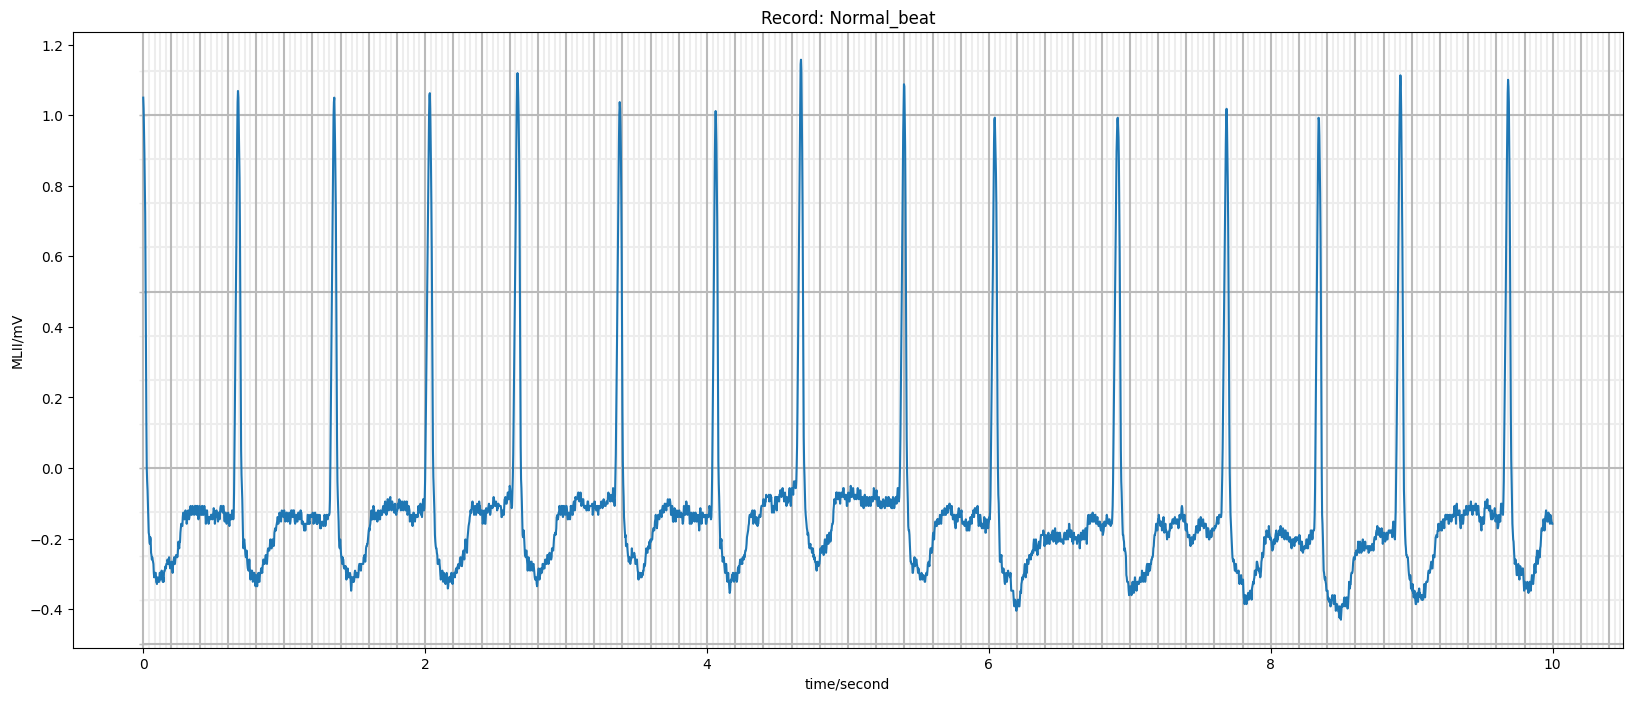

In [32]:
fig = wfdb.plot_wfdb(record=rec,  plot_sym=True, 
                   time_units='seconds',  figsize=(20,8), ecg_grids='all',return_fig = True )
fig.savefig(f'ml_service/visualizations/{name}.png')

# END

## Evaluation Visualization

In [200]:
import matplotlib.pyplot as plt
from numpy import arange

In [201]:
epochs = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]

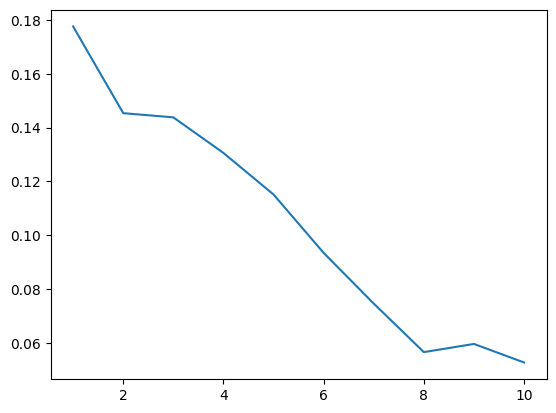

In [202]:
plt.plot(epochs, loss_train)

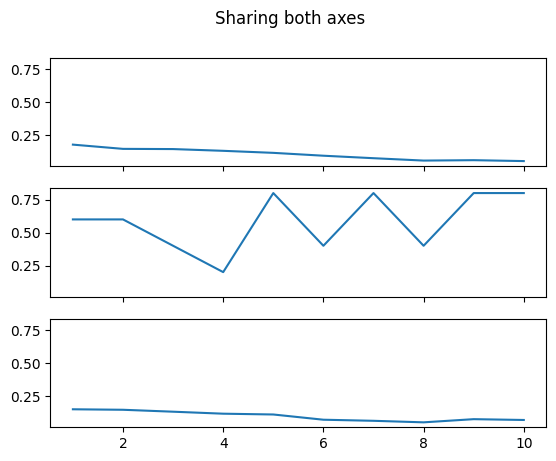

In [203]:
fig, axs = plt.subplots(3, sharex=True, sharey=True)
fig.suptitle('Sharing both axes')
axs[0].plot(epochs, loss_train)
axs[1].plot(epochs, accuracy_train)
axs[2].plot(epochs, validation_set_loss)

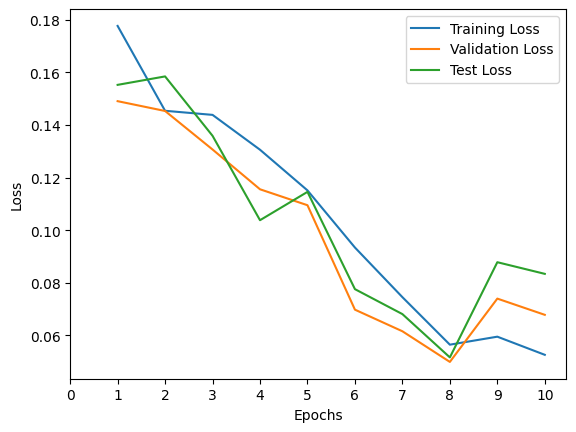

In [204]:
# Plot and label the training and validation loss values
plt.plot(epochs, loss_train, label='Training Loss')
plt.plot(epochs, validation_set_loss, label='Validation Loss')
plt.plot(epochs, loss_test, label='Test Loss')
 
# Add in a title and axes labels
plt.xlabel('Epochs')
plt.ylabel('Loss')
 
# Set the tick locations
plt.xticks(arange(0, 11, 1))
 
# Display the plot
plt.legend(loc='best')
plt.show()
